## DEM extraction

This is the presentation of the DEM emodnet class in dem module.

In [1]:
#to use the full width of the browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import numpy as np

import pyresample

In [3]:
%matplotlib inline 

In [4]:
url = '/Users/brey/DATA/emodnet_bathymetry.nc'

In [5]:
data = xr.open_mfdataset(url)

In [6]:
data

<xarray.Dataset>
Dimensions:    (latitude: 28800, longitude: 37920)
Coordinates:
  * longitude  (longitude) float64 -36.0 -36.0 -35.99 -35.99 -35.99 -35.99 ...
  * latitude   (latitude) float64 25.0 25.0 25.01 25.01 25.01 25.01 25.01 ...
Data variables:
    depth      (latitude, longitude) float64 dask.array<shape=(28800, 37920), chunksize=(28800, 37920)>
Attributes:
    title:          EMODnet Bathymetry
    Institution:    Joint European Research Centre, Directorate for Space, Se...
    Project Name:   COAST
    History:        The file was created by extracting the variable depth fro...
    Creation Date:  20/09/2017
    version:        1.0

In [7]:
#lon range
data.attrs

OrderedDict([(u'title', u'EMODnet Bathymetry'), (u'Institution', u'Joint European Research Centre, Directorate for Space, Security and Migration, Via Enrico Fermi 2749, I-21027-Ispra, Italy'), (u'Project Name', u'COAST'), (u'History', u'The file was created by extracting the variable depth from the original EMODnet *.nc tiles and then merging into one file'), (u'Creation Date', u'20/09/2017'), (u'version', u'1.0')])

In [8]:
data.variables.keys()

[u'longitude', u'latitude', u'depth']

In [9]:
#define the lat/lon window and time frame of interest
minlon = 0. 
maxlon =  13.
minlat = 54.5
maxlat = 66.5

In [10]:
mc = np.mean([minlon,maxlon])
mc

6.5

In [11]:
mt = np.mean([minlat,maxlat])
mt

60.5

In [12]:
data.longitude.min()

<xarray.DataArray 'longitude' ()>
array(-35.998958)

In [13]:
lon=data.longitude.data
lat=data.latitude.data     


In [14]:
if (minlon < lon.min()) or (maxlon > lon.max()): print 'Lon must be within {} and {}'.format(lon.min(),lon.max())
if (minlat < lat.min()) or (maxlat > lat.max()): print 'Lat must be within {} and {}'.format(lat.min(),lat.max())


In [15]:
i1=np.abs(lon-minlon).argmin()
if i1 > 0: i1=i1-1
i2=np.abs(lon-maxlon).argmin()
if i2 < lon.shape : i2=i2+1

j1=np.abs(lat-minlat).argmin()
if j1 > 0: j1=j1-1
j2=np.abs(lat-maxlat).argmin()
if j2 < lat.shape: j2=j2+1


In [16]:
i1,i2,j1,j2

(17279, 23521, 14158, 19920)

In [17]:
lons, lats = np.meshgrid(lon[i1:i2],lat[j1:j2])
topo = data.depth[j1:j2,i1:i2]

In [18]:
emodnet = xr.Dataset({'val': (['dlat', 'dlon'],  topo), 
                      'dlons': (['i', 'j'], lons),   
                      'dlats': (['i', 'j'], lats)}, 
                       coords={'dlon': ('dlon', lons[0,:]),   
                               'dlat': ('dlat', lats[:,0])})         
 

## Resampling on Grid

In [20]:
resolution = .1

In [21]:
ni=int(round((maxlon-minlon)/resolution)) #these are cell numbers
nj=int(round((maxlat-minlat)/resolution))
  
maxlon=minlon+ni*resolution #adjust max lon to much the grid
maxlat=minlat+nj*resolution

        # set the grid 
x=np.linspace(minlon,maxlon,ni)
y=np.linspace(minlat,maxlat,nj)
gx,gy=np.meshgrid(x,y)


In [22]:
grid_x = gx
grid_y = gy
# resample on the given grid
              
orig = pyresample.geometry.SwathDefinition(lons=lons,lats=lats) # original points
targ = pyresample.geometry.SwathDefinition(lons=grid_x,lats=grid_y) # target grid

In [23]:
itopo = pyresample.kd_tree.resample_nearest(orig,topo.values,targ,radius_of_influence=50000,fill_value=np.nan,nprocs=4)

In [24]:
if len(grid_x.shape) > 1: 
                 
    dem = xr.Dataset({'ival': (['ilat', 'ilon'],  itopo), 
                               'ilons': (['k', 'l'], grid_x),   
                               'ilats': (['k', 'l'], grid_y)}, 
                               coords={'ilon': ('ilon', grid_x[0,:]),   
                                       'ilat': ('ilat', grid_y[:,0])})         
elif len(grid_x.shape) == 1:
             
    dem = xr.Dataset({'ival': (['k'],  itopo), 
                        'ilons': (['k'], grid_x),   
                        'ilats': (['k'], grid_y)}
                             )
      
emodnet = xr.merge([emodnet,dem])
       


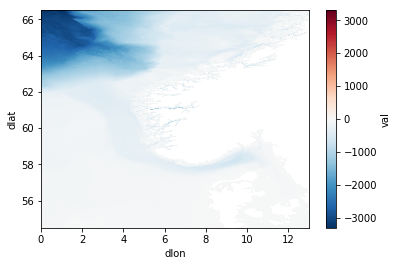

In [27]:
emodnet.val.plot() # original

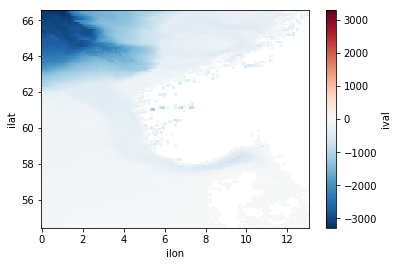

In [28]:
emodnet.ival.plot() #resampled

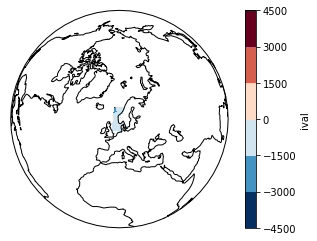

In [26]:
fig, ax = plt.subplots()

ax = plt.axes(projection=ccrs.Orthographic(mc, mt))

emodnet.ival.plot.contourf(ax=ax, transform=ccrs.PlateCarree());

ax.set_global()
ax.coastlines()